# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load the CSV file
df = pd.read_csv("./Stock_Data/clean_stocks.csv") 
df

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,AAPL,2023-02-07,150.639999,155.229996,150.639999,154.649994,154.414230,83322600
1,GOOG,2023-02-07,103.629997,108.669998,103.547997,108.040001,108.040001,33738800
2,MSFT,2023-02-07,260.529999,268.769989,260.079987,267.559998,266.891510,50841400
3,NFLX,2023-02-07,358.510010,364.179993,354.179993,362.950012,362.950012,6289400
4,GOOG,2023-02-08,102.690002,103.580002,98.455002,100.000000,100.000000,73546000
...,...,...,...,...,...,...,...,...
242,NFLX,2023-05-04,319.010010,323.609985,317.950012,320.779999,320.779999,3879700
243,GOOG,2023-05-04,106.160004,106.300003,104.699997,105.209999,105.209999,19780600
244,MSFT,2023-05-05,305.720001,311.970001,304.269989,310.649994,310.649994,28181200
245,NFLX,2023-05-05,323.609985,324.149994,319.440002,322.760010,322.760010,3988600


# 1. Bandas de Bollinger

In [3]:
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['STD_20'] = df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['SMA_20'] + (df['STD_20'] * 2)
df['Lower_Band'] = df['SMA_20'] - (df['STD_20'] * 2)

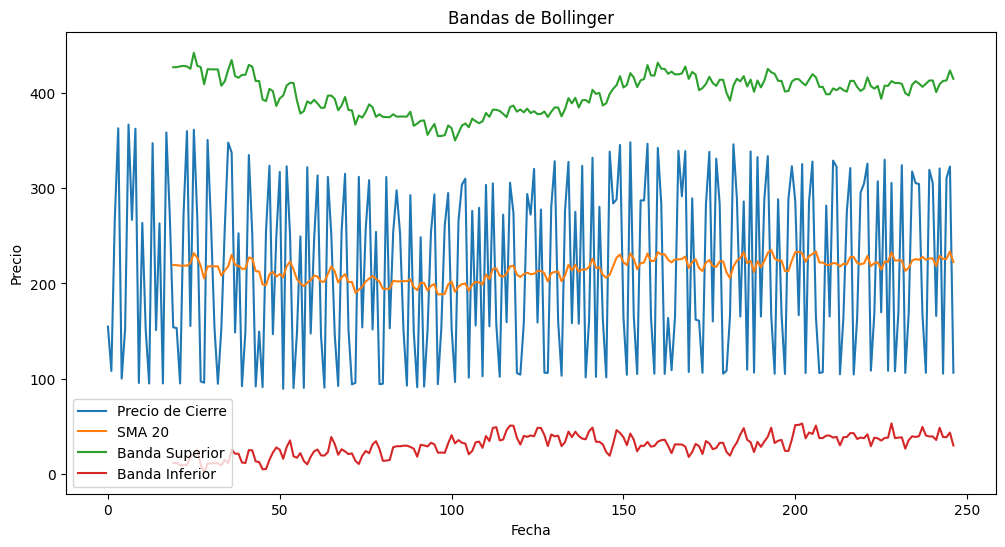

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Precio de Cierre')
plt.plot(df['SMA_20'], label='SMA 20')
plt.plot(df['Upper_Band'], label='Banda Superior')
plt.plot(df['Lower_Band'], label='Banda Inferior')
plt.title('Bandas de Bollinger')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

# 2. Modelo ARIMA

In [5]:
model_arima = ARIMA(df['Close'], order=(5, 1, 0)) #Ajusta el orden (p, d, q) según tus datos
model_arima_fit = model_arima.fit()
forecast_arima = model_arima_fit.forecast(steps=30) #Pronostica los próximos 30 días

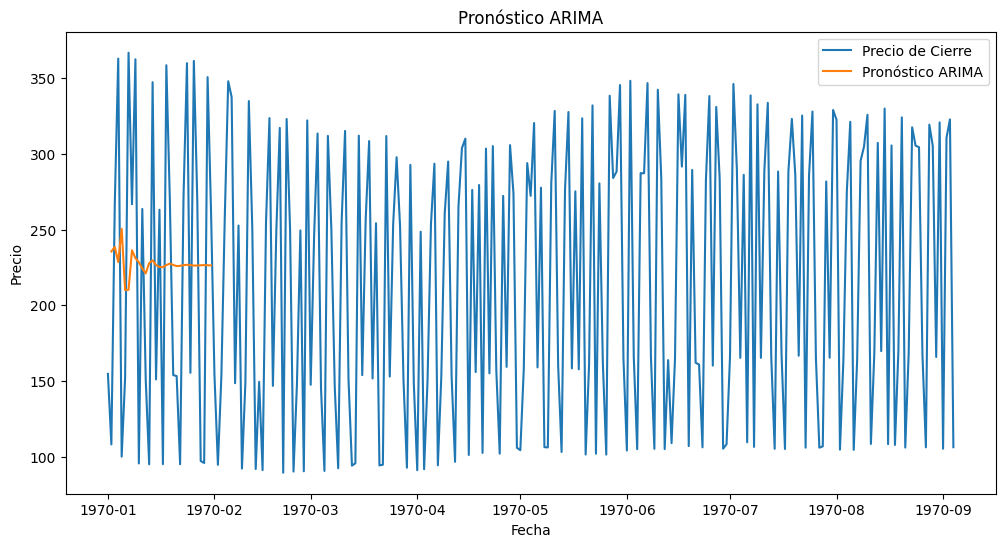

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Precio de Cierre')
plt.plot(pd.date_range(df.index[-1], periods=31, freq='D')[1:], forecast_arima, label='Pronóstico ARIMA')
plt.title('Pronóstico ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

# 3. Modelo de Bosque Aleatorio (Random Forest)

In [7]:
df_rf = df[['Close', 'Volume']].copy()
df_rf['Lag_1'] = df_rf['Close'].shift(1)
df_rf['Lag_2'] = df_rf['Close'].shift(2)
df_rf.dropna(inplace=True)

In [8]:
X = df_rf[['Lag_1', 'Lag_2', 'Volume']]
y = df_rf['Close']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predictions_rf = model_rf.predict(X_test)

In [11]:
mse_rf = mean_squared_error(y_test, predictions_rf)
print(f"Error Cuadrático Medio del Bosque Aleatorio: {mse_rf}")

Error Cuadrático Medio del Bosque Aleatorio: 5584.550837622539


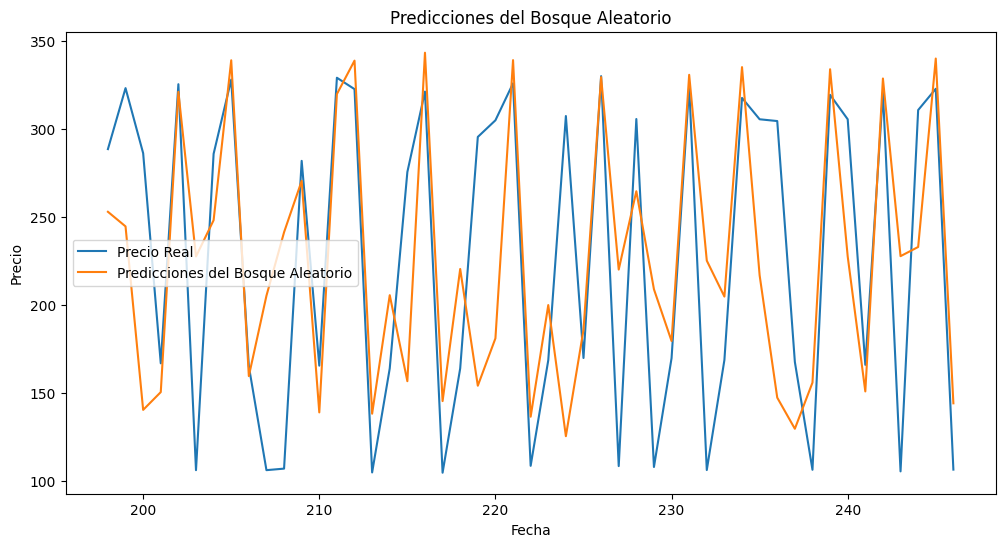

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df_rf.index[-len(y_test):], y_test, label='Precio Real')
plt.plot(df_rf.index[-len(y_test):], predictions_rf, label='Predicciones del Bosque Aleatorio')
plt.title('Predicciones del Bosque Aleatorio')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()